<a href="https://colab.research.google.com/github/tejaspradhan/Face-Generation-from-Textual-Features-using-GANs/blob/main/Stacked_GAN_T2F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [3]:
! mkdir weights tests results_stage2

In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:07<00:00, 177MB/s]
100% 1.33G/1.33G [00:07<00:00, 191MB/s]


In [ ]:
!unzip "/content/celeba-dataset.zip" -d "/content/data"


In [ ]:
! ls /content/data/img_align_celeba/img_align_celeba

# Loading the Data and Embeddings

In [10]:
face_data = pd.read_csv('face_features_preprocessed.csv')

In [11]:
face_data.head()

,Unnamed: 0,image_id,features
0,0,000001.jpg,arched eyebrows attractive brown hair heavy ma...
1,1,000002.jpg,bags under eyes big nose brown hair high cheek...
2,2,000003.jpg,big lips blurry male narrow eyes no beard poin...
3,3,000004.jpg,attractive no beard pointy nose straight hair ...
4,4,000005.jpg,arched eyebrows attractive big lips heavy make...


In [31]:
embeddings = np.load('embeddings_37k.npz')

In [32]:
embeddings.files

['arr_0']

In [33]:
embeddings=embeddings['arr_0'] 

In [34]:
embeddings.shape

(37370, 512)

In [38]:
face_ids = face_data['image_id']

In [39]:
face_ids = face_ids[:37370]

In [42]:
face_ids.shape

(37370,)

(218, 178, 3)


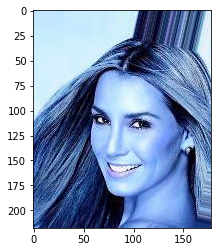

arched eyebrows attractive brown hair heavy makeup high cheekbones mouth slightly open no beard pointy nose smiling straight hair wearing earrings wearing lipstick young female


(512,)

In [48]:
img= cv2.imread('/content/data/img_align_celeba/img_align_celeba/'+face_ids[0])
print(img.shape)
plt.imshow(img)
plt.show()
print(face_data['features'][0])
embeddings[0].shape

In [70]:
real_images = []
for id in range(face_ids):
  img= cv2.imread('/content/data/img_align_celeba/img_align_celeba/'+id)
  


TypeError: ignored

In [93]:
img = cv2.imread('/content/data/img_align_celeba/img_align_celeba/'+face_ids[4])

In [94]:
img.shape

(218, 178, 3)

In [95]:
img.resize((218,178,3),refcheck=False)

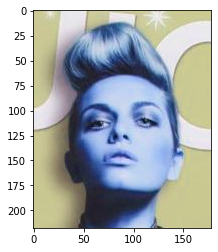

In [96]:
plt.imshow(img)